## SHAP (SHapley Additive exPlanations) 

SHAP explains the output of machine learning models with game theory. SHAP assigns each feature an importance value for a particular prediction.

Example code from https://github.com/shap/shap.

In [1]:
import xgboost
import shap
import transformers
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import time

%matplotlib inline
# print the JS visualization code to the notebook
shap.initjs()

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tree ensemble example (XGBoost)

We will first use the "California Housing Dataset". The dataset is contains data regarding each district in California, and the target contains the median of the house value for each district.

We can isolate a single observation and plot the SHAP values for this one sample.

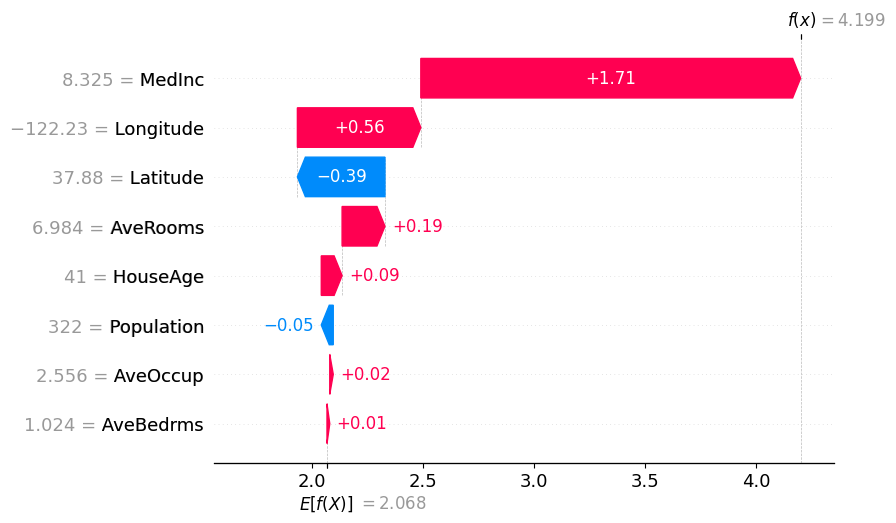

In [2]:
# train an XGBoost model
X, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

The x-axis of the waterfall is house value, the target. x is the set of input values for the model, and f(x) is the prediction from the model. E\[f(X)\] is the base value, which is the average model output over the training dataset we passed. 

The SHAP value shows how much each feature push the model output from the base value to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. The SHAP value for each feature is given by the length of the bar. In this example, Medium Income has a SHAP value of 1.71. 

Another way to visualize the same explanation is to use a force plot.

In [3]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

Again, these SHAP values are valid for this obervation only. Each data point has its own set of SHAP values.

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset.

In [4]:
# visualize all the training set predictions
shap.plots.force(shap_values[:500])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted house price as the latitude changes. Vertical dispersion at a single value of latitude represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. In this case it picks longitude.

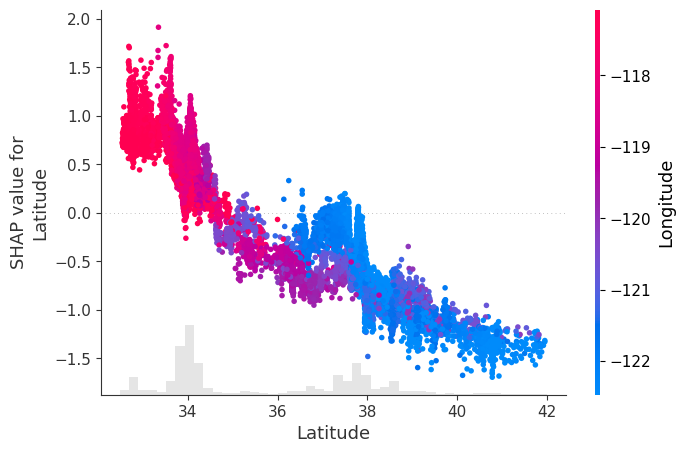

In [5]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "Latitude"], color=shap_values)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 

This plot reveals for example that higher median incomes improves the predicted home price.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

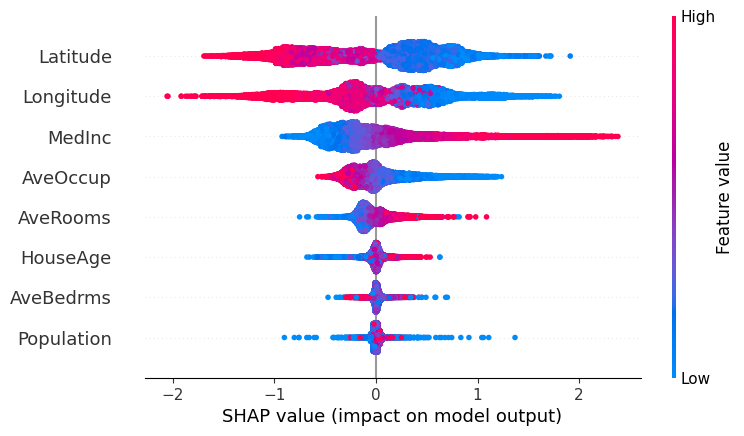

In [6]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot. The calculation uses the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

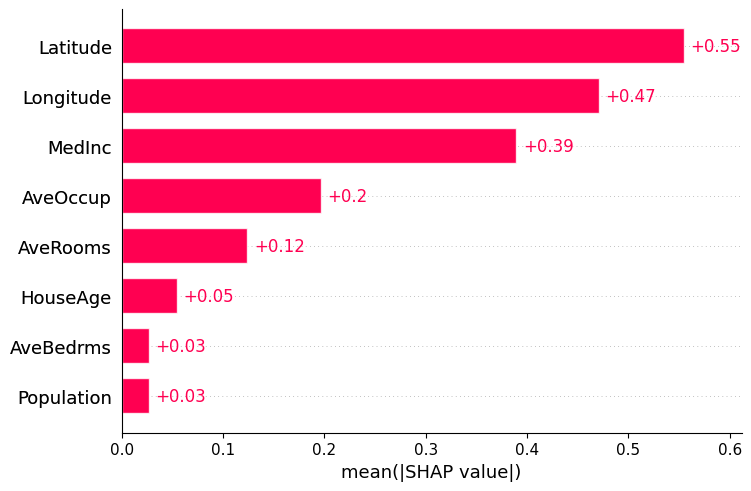

In [7]:
shap.plots.bar(shap_values)

## Natural language example (transformers)

SHAP has specific support for natural language models. Using this functionality is as simple as passing a supported transformers pipeline to SHAP.

In [8]:
# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model)
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0
/usr/local/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Model agnostic example with KernelExplainer (explains any function)

Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset.

In [9]:
# train a SVM classifier
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
# shap simulates "missing" by replacing the feature with the values it takes in the
# background dataset. Using the ``kmeans`` function to summarize the dataset saves time
X_summary = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(svm.predict_proba, X_summary, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test.iloc[0,:], link="logit")

100%|██████████| 30/30 [00:00<00:00, 188.35it/s]


The above explanation shows four features each contributing to push the model output from the base value (the average model output over the training dataset we passed) towards zero. If there were any features pushing the class label higher they would be shown in red.

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset. This is exactly what we do below for all the examples in the iris test set:

In [10]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[:,:,0], X_test, link="logit")

### Compare the speed of KernelExplainer and TreeExplainer

As mentioned in the begining, TreeExplainer is a class that computes SHAP values for tree-based models. Compared to KernelExplainer it’s fast and exact for tree models and ensembles of trees. Let's compare the speed and results for explaining the same XGBoost model with the two different explainers.

Code is based on https://gist.github.com/noleto/05dfa4a691ebbc8816c035b86d2d00d4

In [11]:
# train an XGBoost model
X, y = shap.datasets.california()
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = xgboost.XGBRegressor().fit(X_train, Y_train)

In [12]:
# shap simulates "missing" by replacing the feature with the values it takes in the
# background dataset. Using the ``kmeans`` function to summarize the dataset saves time
X_summary = shap.kmeans(X_train, 10)
def xgb_predict(X):
    return model.predict(X)

shap_kernel_explainer = shap.KernelExplainer(xgb_predict, X_summary)
start = time.time()
## shapely values with kernel SHAP
shap_values_single = shap_kernel_explainer.shap_values(X_test.iloc[[0]])
end = time.time()
print(f"time spent is {end - start}s")
shap.force_plot(shap_kernel_explainer.expected_value, shap_values_single, X_test.iloc[[0]])

100%|██████████| 1/1 [00:00<00:00, 37.11it/s]

time spent is 0.029149770736694336s


In [13]:
## explain the model's predictions using SHAP
#### Tree SHAP
shap_tree_explainer = shap.TreeExplainer(model)
start = time.time()
## shapely values with Tree SHAP
shap_values_single = shap_tree_explainer.shap_values(X_test.iloc[[0]])
end = time.time()
print(f"time spent is {end - start}s")
shap.force_plot(shap_tree_explainer.expected_value, shap_values_single, X_test.iloc[[0]])

time spent is 0.0053882598876953125s
